# **Retail Sales Analysis Notebook**

## Objectives

* **Extract retail datasets from Kaggle** and load into pandas DataFrames for analysis
* **Create comprehensive data dictionaries** to understand data quality, missing values, and column relationships across datasets
* **Transform and normalize datasets** including date parsing, duplicate removal, and referential integrity validation
* **Join multiple datasets** into denormalized tables using star schema relationships (Sales as fact table, Stores/Features as dimensions)
* **Create analysis-ready datasets** optimized for different use cases (full timeline vs promotional period analysis)

## Inputs

** **Kaggle retail dataset** (manjeetsingh/retaildataset) containing:
  - `sales-data-set.csv`: Weekly sales by store and department
  - `stores-data-set.csv`: Store characteristics and classifications  
  - `features-data-set.csv`: Economic indicators, weather, and promotional data

* **Raw datasets** loaded directly from CSV files with minimal processing:
    - `sales_df_raw`: Unprocessed sales data with original date formats and data types
    - `stores_df_raw`: Store master data in original format
    - `features_df_raw`: Economic and promotional features with original missing value patterns

## Tranformations

** Description of tyranformation steps and order to go here.

* **Transform datasets** created for data cleaning and preparation:
    - `sales_df_transform`: Sales data with converted date formats and validated structure
    - `stores_df_transform`: Store data prepared for joining operations
    - `features_df_transform`: Features data with date conversion, duplicate column removal, and date range trimming

## Outputs

* Here I will explain denormalised_df (clean) and promo_denormalised_df (clean)

* **Analysis-ready datasets** optimized for specific analytical purposes:
    - `sales_df`: Complete denormalized dataset for general sales analysis (full timeline)
    - `promo_sales_df`: Promotional analysis dataset with complete markdown features (Nov 2011 onwards)

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Data Extract & Dictionary Creation

In [235]:
# Core Libraries
import pandas as pd                        # Data manipulation and analysis
import numpy as np                         # Numerical computing and operations

# Visualization Libraries
import matplotlib.pyplot as plt            # Basic plotting and charting
import seaborn as sns                      # Statistical data visualisation

In [236]:
# Directory Management
import os                                  # Import os for data directory management
import shutil                              # Import shutil for file operations

# Data Acquisition Library
import kagglehub                           # Import Kaggle Hub to Download retail datasets

# Download dataset 
path = kagglehub.dataset_download("manjeetsingh/retaildataset")
print(f'Files downloaded to: {path}')

# Copy CSV files to data directory
os.makedirs("../data", exist_ok=True)
for file in os.listdir(path):
    if file.endswith(".csv"):
        shutil.copy2(os.path.join(path, file), f"../data/{file.lower().replace(' ', '-')}")

# backlog feat: remove files from the kaggle cashe folder on copy see ≈
# https://github.com/users/Julian-Elliott/projects/3/views/1?pane=issue&itemId=115149029&issue=Julian-Elliott%7Cretail-sales-analysis%7C13
print("Files copied to ../data")

Files downloaded to: /Users/julianelliott/.cache/kagglehub/datasets/manjeetsingh/retaildataset/versions/2
Files copied to ../data


In [237]:
# Load the retail datasets into dataframes
sales_df_raw = pd.read_csv("../data/sales-data-set.csv")
stores_df_raw = pd.read_csv("../data/stores-data-set.csv") 
features_df_raw = pd.read_csv("../data/features-data-set.csv")

### Inspecting Dataset Data and building a data dictionary

In [238]:
# Custom Function to create a comprehensive data dictionary for multiple datasets as I experienced issues with ydata-profiling
def create_data_dictionary(datasets_dict):
    # Quick ref for detailed descriptions for each known column (from Kaggle data card https://www.kaggle.com/datasets/manjeetsingh/retaildataset/data)
    descriptions = {
        'Store': 'The store number',
        'Date': 'The week start date',
        'Temperature': 'Average temperature in the region',
        'Fuel_Price': 'Cost of fuel in the region',
        'MarkDown1': 'Anonymized promotional markdown data (after Nov 2011)',
        'MarkDown2': 'Anonymized promotional markdown data (after Nov 2011)',
        'MarkDown3': 'Anonymized promotional markdown data (after Nov 2011)',
        'MarkDown4': 'Anonymized promotional markdown data (after Nov 2011)',
        'MarkDown5': 'Anonymized promotional markdown data (after Nov 2011)',
        'CPI': 'The consumer price index',
        'Unemployment': 'The unemployment rate',
        'IsHoliday': 'Whether the week is a special holiday week',
        'Dept': 'The department number',
        'Weekly_Sales': 'Sales for the given department in the given store',
        'Type': 'Store type classification',
        'Size': 'Store size in square feet'
    }
    
    dictionary_data = []
    for dataset_name, df in datasets_dict.items():
        for column in df.columns:
            # Get 3 sample values (non-null)
            sample_values = df[column].dropna().head(3).tolist()
            sample_str = ', '.join([str(x) for x in sample_values])
            
            dictionary_data.append({
                'Dataset': dataset_name,
                'Column': column,
                'Data Type': str(df[column].dtype),
                'Row Count': len(df),
                'Missing Values': df[column].isnull().sum(),
                'Missing %': round((df[column].isnull().sum() / len(df)) * 100, 2),
                'Unique Values': df[column].nunique(),
                'Sample Values': sample_str,
                'Description': descriptions.get(column, 'Description needed')
            })
    return pd.DataFrame(dictionary_data)

# Create datasets dictionary
datasets = {
    'sales_df_raw': sales_df_raw,
    'stores_df_raw': stores_df_raw,
    'features_df_raw': features_df_raw
}

# Generate data dictionary that can be called upon later
data_dictionary = create_data_dictionary(datasets)

print('\nRaw data Dictionary (before transformation)')
# Display data dictionary
data_dictionary


Raw data Dictionary (before transformation)


,Dataset,Column,Data Type,Row Count,Missing Values,Missing %,Unique Values,Sample Values,Description
0,sales_df_raw,Store,int64,421570,0,0.00,45,"1, 1, 1",The store number
1,sales_df_raw,Dept,int64,421570,0,0.00,81,"1, 1, 1",The department number
2,sales_df_raw,Date,object,421570,0,0.00,143,"05/02/2010, 12/02/2010, 19/02/2010",The week start date
3,sales_df_raw,Weekly_Sales,float64,421570,0,0.00,359464,"24924.5, 46039.49, 41595.55",Sales for the given department in the given store
4,sales_df_raw,IsHoliday,bool,421570,0,0.00,2,"False, True, False",Whether the week is a special holiday week
5,stores_df_raw,Store,int64,45,0,0.00,45,"1, 2, 3",The store number
6,stores_df_raw,Type,object,45,0,0.00,3,"A, A, B",Store type classification
7,stores_df_raw,Size,int64,45,0,0.00,40,"151315, 202307, 37392",Store size in square feet
8,features_df_raw,Store,int64,8190,0,0.00,45,"1, 1, 1",The store number
9,features_df_raw,Date,object,8190,0,0.00,182,"05/02/2010, 12/02/2010, 19/02/2010",The week start date


#### Potential Issues shown in the Data Dictionary

Markdown columns `1` through `5`, `CPI` and `Unemployment` in the `Features` dataset presents notable data quality challenges:

- **Missing Data:**  
  Each MarkDown column contains a significant percentage of missing values (ranging from 50% to over 64%). Part of this is expected, as promotional markdown data is only available after November 2011, and earlier records do not include these values.  
  To a lesser extent, the `CPI` (Consumer Price Index) and `Unemployment` columns are also missing about 7% of their values. While this is less dramatic, it may still impact analyses involving economic features of our dataset.
  
- **Time-Dependent Availability:**  
  The fact that MarkDown data is only present for dates after November 2011 (as explained in the kaggle [data card](https://www.kaggle.com/datasets/manjeetsingh/retaildataset/data)) means that analyses involving these columns must account for their partial availability. Any models or insights involving markdowns will be biased toward the later part of the dataset and may not generalise to earlier periods.

- **Other Features:**  
  Other columns such as `Store`, `Date`, `Temperature`, `IsHoliday` and `Weekly_Sales` have no missing values and can be used with greater confidence in a general analyses.

In [239]:
# Create temporary dataframes to avoid modifying the original data before transform stage
sales_df_transform = sales_df_raw.copy()
features_df_transform = features_df_raw.copy()
stores_df_transform = stores_df_raw.copy()

# Convert temp date columns with correct format (DD/MM/YYYY)
sales_df_transform['Date'] = pd.to_datetime(sales_df_transform['Date'], format='%d/%m/%Y')
features_df_transform['Date'] = pd.to_datetime(features_df_transform['Date'], format='%d/%m/%Y')

# Find the first date where any MarkDown data is available
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
first_markdown_date = features_df_transform[features_df_transform[markdown_cols].notna().any(axis=1)]['Date'].min()

In [240]:
# Create a summary dataframe of the datasets with date ranges and markdown info
dataset_summary = pd.DataFrame({
    'Dataset': ['sales-data-set.csv', 'features-data-set.csv', 'markdown-features'],
    'Records': [
        sales_df_transform.shape[0], 
        features_df_transform.shape[0], 
        features_df_transform[features_df_transform[markdown_cols].notna().any(axis=1)].shape[0]
    ],
    'Start_Date': [
        sales_df_transform["Date"].min().strftime("%Y-%m-%d"),  # Sales data start date using transform df
        features_df_transform["Date"].min().strftime("%Y-%m-%d"),  # Features data start date using transform df
        first_markdown_date.strftime("%Y-%m-%d")  # First date with markdown data
    ],
    'End_Date': [
        sales_df_transform["Date"].max().strftime("%Y-%m-%d"),  # Sales data end date using transform df
        features_df_transform["Date"].max().strftime("%Y-%m-%d"),  # Features data end date using transform df
        features_df_transform["Date"].max().strftime("%Y-%m-%d")  # Markdown data shares same end date as features
    ],
    'Description': [
        f'Weekly sales data spanning {stores_df_raw.shape[0]} stores',  # Sales dataset description
        'Economic and promotional features',  # Features dataset description
        f'Promotional markdown data'  # Markdown subset description
    ]
})

print('\nComparison of date ranges across datasets:')

dataset_summary


Comparison of date ranges across datasets:


,Dataset,Records,Start_Date,End_Date,Description
0,sales-data-set.csv,421570,2010-02-05,2012-10-26,Weekly sales data spanning 45 stores
1,features-data-set.csv,8190,2010-02-05,2013-07-26,Economic and promotional features
2,markdown-features,4050,2011-11-11,2013-07-26,Promotional markdown data


In [241]:
# Use data dictionary to identify matching columns between transform datasets
transform_datasets = {
    'Sales_Transform': sales_df_transform,
    'Stores_Transform': stores_df_transform, 
    'Features_Transform': features_df_transform
}

# Generate data dictionary for transform datasets
transform_dictionary = create_data_dictionary(transform_datasets)

# Find columns that appear in multiple datasets
column_counts = transform_dictionary['Column'].value_counts()
shared_columns = column_counts[column_counts > 1]

print("SHARED COLUMNS (JOIN KEYS):")
# Only show rows for columns that appear in multiple datasets
shared_dict = transform_dictionary[transform_dictionary['Column'].isin(shared_columns.index)]
shared_dict[['Dataset', 'Column', 'Data Type', 'Unique Values']].sort_values('Column')


SHARED COLUMNS (JOIN KEYS):


,Dataset,Column,Data Type,Unique Values
2,Sales_Transform,Date,datetime64[ns],143
9,Features_Transform,Date,datetime64[ns],182
4,Sales_Transform,IsHoliday,bool,2
19,Features_Transform,IsHoliday,bool,2
0,Sales_Transform,Store,int64,45
5,Stores_Transform,Store,int64,45
8,Features_Transform,Store,int64,45


### Data Relationships Between Tables

The retail dataset appears to follow a **Star Schema** pattern with clear relationships between the three main tables:

#### **Join Keys Identified**
- **Sales ↔ Stores**: `Store` (Many-to-One relationship)
- **Sales ↔ Features**: `Store` + `Date` composite key (One-to-One relationship)

#### **Table Roles**
- **SALES**: Central fact table containing transactional data
  - Granularity: Store + Department + Week level
  - Contains measurable metrics (Weekly_Sales)
  
- **STORES**: Dimension table with store characteristics
  - Granularity: Store level (static attributes)
  - Contains: Store type, size, and other store properties
  
- **FEATURES**: Dimension table with temporal/environmental factors
  - Granularity: Store + Week level (time-varying attributes)
  - Contains: Economic indicators, weather, promotions, holidays

#### **Duplicate column**
- **IsHoliday**: Column does not appear to be needed for referencial integrety, one option can be dropped.

In [242]:
# Drop duplicate IsHoliday column from features_df to avoid redundancy
# Keep IsHoliday in sales_df as it's the primary fact table
features_df_transform = features_df_transform.drop('IsHoliday', axis=1)

print("Dropped duplicate IsHoliday column from features dataset")

Dropped duplicate IsHoliday column from features dataset


In [243]:
# Check for orphaned keys between datasets
# Trim features table by last sales date
last_sales_date = sales_df_transform['Date'].max()
features_df_transform = features_df_transform[features_df_transform['Date'] <= last_sales_date]
print(f"Features table trimmed to end at {last_sales_date.strftime('%Y-%m-%d')}")

# Store comparisons
sales_stores = set(sales_df_transform['Store'].unique())
master_stores = set(stores_df_transform['Store'].unique())
orphaned_sales_stores = sales_stores - master_stores
orphaned_master_stores = master_stores - sales_stores

print(f"\nOrphaned stores in Sales (not in master): {len(orphaned_sales_stores)}")
print(f"Orphaned stores in Master (not in sales): {len(orphaned_master_stores)}")

# Store-date combinations
sales_keys = set(zip(sales_df_transform['Store'], sales_df_transform['Date']))
features_keys = set(zip(features_df_transform['Store'], features_df_transform['Date']))
orphaned_sales = sales_keys - features_keys
orphaned_features = features_keys - sales_keys

print(f"\nOrphaned sales combinations without features: {len(orphaned_sales):,}")
print(f"Orphaned features combinations without sales: {len(orphaned_features):,}")

Features table trimmed to end at 2012-10-26

Orphaned stores in Sales (not in master): 0
Orphaned stores in Master (not in sales): 0

Orphaned sales combinations without features: 0
Orphaned features combinations without sales: 0


### Joining the Tables

It appears that there aren't any orphaned keys, I can use LEFT JOIN or INNER JOIN with the same result

In [244]:
# Left join merge of definitions and feature definitions to the sales fact table

# Create complete dataset with all three tables joined
denormalised_df_transform = sales_df_transform.merge(stores_df_transform, on='Store', how='left') \
                           .merge(features_df_transform, on=['Store', 'Date'], how='left')

print(f"Denormalised dataset: {denormalised_df_transform.shape[0]:,} records, {denormalised_df_transform.shape[1]} columns")
print(f"Original sales records: {sales_df_transform.shape[0]:,} records, {sales_df_transform.shape[1]} columns")

# Verify join success - check for any null values in key columns
null_stores = denormalised_df_transform['Type'].isnull().sum()
null_features = denormalised_df_transform['Temperature'].isnull().sum()

print(f"\nJoin validation:")
print(f"Missing store data after join: {null_stores}")
print(f"Missing feature data after join: {null_features}")

# Display sample of joined data
print(f"\nHead of denormalised dataset:")
denormalised_df_transform.head()

Denormalised dataset: 421,570 records, 16 columns
Original sales records: 421,570 records, 5 columns

Join validation:
Missing store data after join: 0
Missing feature data after join: 0

Head of denormalised dataset:


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


### Dataset Splitting Strategy

Based on the date range data quality issues identified above, we'll create **two analysis datasets** to maximize data utility:

#### **Dataset 1: General Analysis (Full Sales data Timeline)**
- **Purpose:** Sales trends, seasonality, store performance analysis
- **Timeline:** Complete sales data dataset (Feb 2010 - Oct 2012)
- **Features:** Store, Date, Temperature, Fuel_Price, CPI, Unemployment, IsHoliday, Weekly_Sales
- **Advantage:** Maximum data coverage for robust trend analysis

#### **Dataset 2: Promotion and Markdown Analysis (Nov 2011 onwards)**
- **Purpose:** Impact of markdowns and promotional strategies
- **Timeline:** From Nov 2011 when MarkDown data becomes available - Oct 2012
- **Features:** All features including MarkDown 1-5 columns
- **Advantage:** Complete feature set for promotional impact analysis

This approach allows me to:
- **Maximise data usage** - Use full timeline where appropriate
- **Maintain data quality** - Focus on complete records for markdown analysis
- **Enable comprehensive insights** - Compare pre/post promotional periods

---

#### Implementing the Split

**Naming Conventions:**
- General analysis datasets: Keep existing names (`denormalised_df`)
- Promotional analysis datasets: Use `promo_` prefix (`promo_denormalised_df`)

In [245]:
# Create promotional datasets (from first markdown date onwards) using the denormalised table
promo_denormalised_df_transform = denormalised_df_transform[denormalised_df_transform['Date'] >= first_markdown_date].copy()

# Create promotional datasets dictionary
promo_datasets = {
    'promo_denormalised_df_transform': promo_denormalised_df_transform
}

# Generate data dictionary for promotional datasets
promo_data_dictionary = create_data_dictionary(promo_datasets)

print(f'Promotional dataset created from denormalised table starting {first_markdown_date.strftime("%Y-%m-%d")}:')

# Display promotional data dictionary filtered for rows with missing values
promo_data_dictionary[promo_data_dictionary['Missing Values'] > 0]

Promotional dataset created from denormalised table starting 2011-11-11:


,Dataset,Column,Data Type,Row Count,Missing Values,Missing %,Unique Values,Sample Values,Description
9,promo_denormalised_df_transform,MarkDown1,float64,151432,751,0.50,2277,"10382.9, 6074.12, 410.31",Anonymized promotional markdown data (after No...
10,promo_denormalised_df_transform,MarkDown2,float64,151432,40184,26.54,1499,"6115.67, 254.39, 98.0",Anonymized promotional markdown data (after No...
11,promo_denormalised_df_transform,MarkDown3,float64,151432,14341,9.47,1662,"215.07, 51.98, 55805.51",Anonymized promotional markdown data (after No...
12,promo_denormalised_df_transform,MarkDown4,float64,151432,16465,10.87,1944,"2406.62, 427.39, 8.0",Anonymized promotional markdown data (after No...


### Data Quality Assessment & Bias Detection

Before finalising our analysis-ready datasets, I need to conduct comprehensive data quality checks and bias detection to ensure reliable insights. This critical step addresses several key concerns:

**1. Missing Data Patterns**
- **CPI/Unemployment**: ~7% missing values could indicate systematic gaps
- **MarkDown columns**: 50-64% missing by design (pre-Nov 2011), but need to verify no additional patterns
- **Impact**: Missing data can skew analyses and lead to biased conclusions

**2. Temporal Bias Detection**
- **Issue**: MarkDown data creates a natural split in our timeline (Feb 2010 vs Nov 2011+)
- **Risk**: Promotional analysis may not represent earlier periods
- **Need**: Validate that pre/post periods are comparable for trend analysis

**3. Store Representation Bias**
- **Concern**: Different store types (A, B, C) may have different data quality or economic conditions
- **Risk**: Results may be dominated by one store type or geographic region
- **Validation**: Ensure balanced representation across store characteristics

**4. Economic Condition Bias**
- **Issue**: Stores operate in different economic environments (CPI, unemployment, fuel prices)
- **Risk**: Economic conditions may confound promotional effects
- **Need**: Identify and control for regional economic differences

#### **Analysis Strategy**

We'll conduct this assessment **before** creating final clean datasets to:
- **Identify problematic patterns** that require special handling
- **Determine imputation strategies** for missing economic data
- **Document data limitations** for transparent analysis
- **Ensure representative sampling** across store types and time periods

This proactive approach prevents downstream analytical bias and ensures my insights are robust and generalisable.

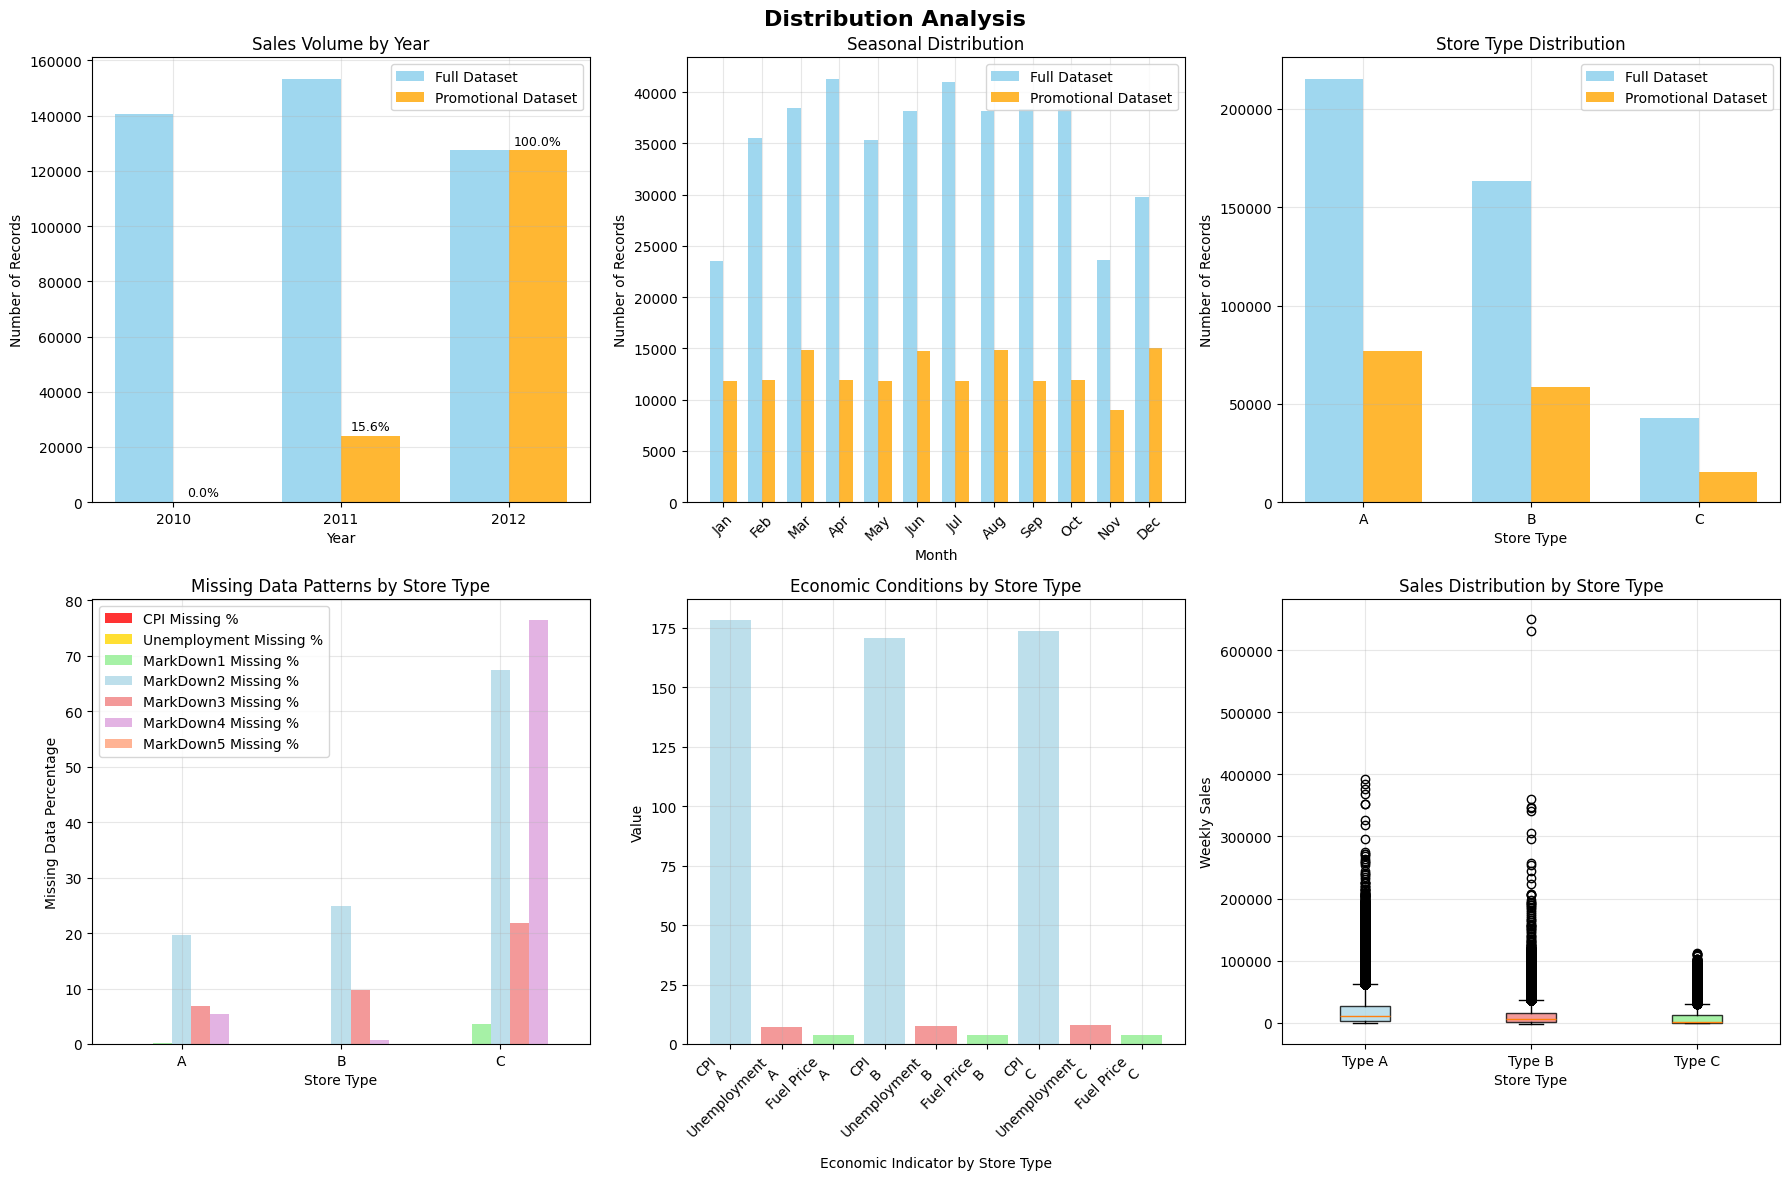

In [246]:
# Distribution analysis with charts

# TEMPORAL BIAS DATA - Sales volume by year
full_period = denormalised_df_transform['Date'].dt.year.value_counts().sort_index()
promo_period = promo_denormalised_df_transform['Date'].dt.year.value_counts().sort_index()

# SEASONAL BIAS DATA - Monthly distribution
seasonal_full = denormalised_df_transform.groupby(denormalised_df_transform['Date'].dt.month)['Weekly_Sales'].agg(['count', 'mean']).round(2)
seasonal_promo = promo_denormalised_df_transform.groupby(promo_denormalised_df_transform['Date'].dt.month)['Weekly_Sales'].agg(['count', 'mean']).round(2)

# STORE TYPE BIAS DATA - Store representation
store_bias_full = denormalised_df_transform.groupby(['Type']).agg({
    'Weekly_Sales': ['count', 'mean', 'std'],
    'Store': 'nunique'
}).round(2)

store_bias_promo = promo_denormalised_df_transform.groupby(['Type']).agg({
    'Weekly_Sales': ['count', 'mean', 'std'],
    'Store': 'nunique'
}).round(2)

# ECONOMIC CONDITIONS DATA
economic_cols = ['CPI', 'Unemployment']
economic_stats = promo_denormalised_df_transform.groupby('Type')[economic_cols + ['Fuel_Price']].agg(['mean', 'std']).round(2)

# STORE TYPES for sales distribution
store_types = promo_denormalised_df_transform['Type'].unique()

# Set up plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution Analysis', fontsize=16, fontweight='bold')

# TEMPORAL BIAS - Sales volume by year
temporal_bias_chart = axes[0, 0]
years = sorted(full_period.index)
full_counts = [full_period.get(year, 0) for year in years]
promo_counts = [promo_period.get(year, 0) for year in years]

x = np.arange(len(years))
width = 0.35

temporal_bias_chart.bar(x - width/2, full_counts, width, label='Full Dataset', alpha=0.8, color='skyblue')
temporal_bias_chart.bar(x + width/2, promo_counts, width, label='Promotional Dataset', alpha=0.8, color='orange')
temporal_bias_chart.set_xlabel('Year')
temporal_bias_chart.set_ylabel('Number of Records')
temporal_bias_chart.set_title('Sales Volume by Year')
temporal_bias_chart.set_xticks(x)
temporal_bias_chart.set_xticklabels(years)
temporal_bias_chart.legend()
temporal_bias_chart.grid(True, alpha=0.3)

# Add percentage
for i, (full, promo) in enumerate(zip(full_counts, promo_counts)):
    if full > 0:
        pct = (promo / full * 100)
        temporal_bias_chart.text(i + width/2, promo + 1000, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

# SEASONAL BIAS - Monthly distribution
seasonal_distribution_chart = axes[0, 1]
months = range(1, 13)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

full_monthly = [seasonal_full.loc[month, 'count'] if month in seasonal_full.index else 0 for month in months]
promo_monthly = [seasonal_promo.loc[month, 'count'] if month in seasonal_promo.index else 0 for month in months]

x = np.arange(len(months))
seasonal_distribution_chart.bar(x - width/2, full_monthly, width, label='Full Dataset', alpha=0.8, color='skyblue')
seasonal_distribution_chart.bar(x + width/2, promo_monthly, width, label='Promotional Dataset', alpha=0.8, color='orange')
seasonal_distribution_chart.set_xlabel('Month')
seasonal_distribution_chart.set_ylabel('Number of Records')
seasonal_distribution_chart.set_title('Seasonal Distribution')
seasonal_distribution_chart.set_xticks(x)
seasonal_distribution_chart.set_xticklabels(month_names, rotation=45)
seasonal_distribution_chart.legend()
seasonal_distribution_chart.grid(True, alpha=0.3)

# STORE TYPE BIAS - Store representation
store_type_distribution_chart = axes[0, 2]
store_types_list = list(store_bias_full.index)
full_store_counts = [store_bias_full.loc[st, ('Weekly_Sales', 'count')] for st in store_types_list]
promo_store_counts = [store_bias_promo.loc[st, ('Weekly_Sales', 'count')] if st in store_bias_promo.index else 0 
                     for st in store_types_list]

x = np.arange(len(store_types_list))
store_type_distribution_chart.bar(x - width/2, full_store_counts, width, label='Full Dataset', alpha=0.8, color='skyblue')
store_type_distribution_chart.bar(x + width/2, promo_store_counts, width, label='Promotional Dataset', alpha=0.8, color='orange')
store_type_distribution_chart.set_xlabel('Store Type')
store_type_distribution_chart.set_ylabel('Number of Records')
store_type_distribution_chart.set_title('Store Type Distribution')
store_type_distribution_chart.set_xticks(x)
store_type_distribution_chart.set_xticklabels(store_types_list)
store_type_distribution_chart.legend()
store_type_distribution_chart.grid(True, alpha=0.3)

# MISSING DATA PATTERNS by store type
missing_data_patterns_chart = axes[1, 0]
store_types_unique = promo_denormalised_df_transform['Type'].unique()
cpi_missing_by_type = []
unemployment_missing_by_type = []
markdown1_missing_by_type = []
markdown2_missing_by_type = []
markdown3_missing_by_type = []
markdown4_missing_by_type = []
markdown5_missing_by_type = []

for store_type in store_types_unique:
    subset = promo_denormalised_df_transform[promo_denormalised_df_transform['Type'] == store_type]
    cpi_missing_by_type.append(subset['CPI'].isnull().sum() / len(subset) * 100)
    unemployment_missing_by_type.append(subset['Unemployment'].isnull().sum() / len(subset) * 100)
    markdown1_missing_by_type.append(subset['MarkDown1'].isnull().sum() / len(subset) * 100)
    markdown2_missing_by_type.append(subset['MarkDown2'].isnull().sum() / len(subset) * 100)
    markdown3_missing_by_type.append(subset['MarkDown3'].isnull().sum() / len(subset) * 100)
    markdown4_missing_by_type.append(subset['MarkDown4'].isnull().sum() / len(subset) * 100)
    markdown5_missing_by_type.append(subset['MarkDown5'].isnull().sum() / len(subset) * 100)

x = np.arange(len(store_types_unique))
width = 0.12  # Narrower bars to fit all 7 variables

missing_data_patterns_chart.bar(x - 3*width, cpi_missing_by_type, width, label='CPI Missing %', alpha=0.8, color='red')
missing_data_patterns_chart.bar(x - 2*width, unemployment_missing_by_type, width, label='Unemployment Missing %', alpha=0.8, color='gold')
missing_data_patterns_chart.bar(x - width, markdown1_missing_by_type, width, label='MarkDown1 Missing %', alpha=0.8, color='lightgreen')
missing_data_patterns_chart.bar(x, markdown2_missing_by_type, width, label='MarkDown2 Missing %', alpha=0.8, color='lightblue')
missing_data_patterns_chart.bar(x + width, markdown3_missing_by_type, width, label='MarkDown3 Missing %', alpha=0.8, color='lightcoral')
missing_data_patterns_chart.bar(x + 2*width, markdown4_missing_by_type, width, label='MarkDown4 Missing %', alpha=0.8, color='plum')
missing_data_patterns_chart.bar(x + 3*width, markdown5_missing_by_type, width, label='MarkDown5 Missing %', alpha=0.8, color='lightsalmon')

missing_data_patterns_chart.set_xlabel('Store Type')
missing_data_patterns_chart.set_ylabel('Missing Data Percentage')
missing_data_patterns_chart.set_title('Missing Data Patterns by Store Type')
missing_data_patterns_chart.set_xticks(x)
missing_data_patterns_chart.set_xticklabels(store_types_unique)
missing_data_patterns_chart.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
missing_data_patterns_chart.grid(True, alpha=0.3)
missing_data_patterns_chart.legend(loc='upper left')

# ECONOMIC CONDITIONS by store type
economic_conditions_chart = axes[1, 1]
economic_means = []
economic_stds = []
econ_labels = []

for store_type in economic_stats.index:
    cpi_mean = economic_stats.loc[store_type, ('CPI', 'mean')]
    unemp_mean = economic_stats.loc[store_type, ('Unemployment', 'mean')]
    fuel_mean = economic_stats.loc[store_type, ('Fuel_Price', 'mean')]
    
    economic_means.extend([cpi_mean, unemp_mean, fuel_mean])
    econ_labels.extend([f'CPI\n{store_type}', f'Unemployment\n{store_type}', f'Fuel Price\n{store_type}'])

colors = ['lightblue', 'lightcoral', 'lightgreen'] * len(economic_stats.index)
bars = economic_conditions_chart.bar(range(len(economic_means)), economic_means, color=colors, alpha=0.8)
economic_conditions_chart.set_xlabel('Economic Indicator by Store Type')
economic_conditions_chart.set_ylabel('Value')
economic_conditions_chart.set_title('Economic Conditions by Store Type')
economic_conditions_chart.set_xticks(range(len(econ_labels)))
economic_conditions_chart.set_xticklabels(econ_labels, rotation=45, ha='right')
economic_conditions_chart.grid(True, alpha=0.3)

# SALES DISTRIBUTION by store type (Box plot)
sales_distribution_chart = axes[1, 2]
sales_data_by_type = []
labels = []

for store_type in store_types:
    sales_data = promo_denormalised_df_transform[promo_denormalised_df_transform['Type'] == store_type]['Weekly_Sales'].dropna()
    sales_data_by_type.append(sales_data)
    labels.append(f'Type {store_type}')

box_plot = sales_distribution_chart.boxplot(sales_data_by_type, labels=labels, patch_artist=True)
colors = ['lightblue', 'lightcoral', 'lightgreen']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

sales_distribution_chart.set_xlabel('Store Type')
sales_distribution_chart.set_ylabel('Weekly Sales')
sales_distribution_chart.set_title('Sales Distribution by Store Type')
sales_distribution_chart.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Mitigating Bias in the Promo Data Slice

The high missingness in Markdown2–4 creates a trade-off: imputing many values can dilute true signals, while dropping rows shifts representation away from Type C stores. To address this, I will apply the following strategies:

1. **Model 1: Prioritise Markdown1**  
   Since Markdown1 is over 95 % complete across all stores, it will serve as the primary variable. Secondary markdowns will be treated as exploratory.

2. **Model 2: Model missingness directly**  
   For MD2–4, introduce binary flags (`MD2_missing`, `MD3_missing`, `MD4_missing`) to capture when a store did not apply a second, third or fourth markdown, rather than dropping or imputing those records.

3. **Compare modelling approaches**  

### Hypothesis: Missingness Indicators as Promotional Strategy Signals

Based on the model comparison results, I hypothesize that **missing markdown data is not random** but represents a deliberate promotional strategy signal. The findings support this interpretation:

#### **Key Evidence**

1. **Significant Negative Coefficients for Missingness Indicators**
    - MD2_missing: -1,532.8 (highly significant, p < 0.001)
    - MD3_missing: -3,064.8 (highly significant, p < 0.001)  
    - MD4_missing: -6,673.9 (highly significant, p < 0.001)

2. **Escalating Impact Pattern**
    - The negative effect increases dramatically from MD2 → MD3 → MD4
    - This suggests that stores using fewer markdown

In [247]:
# Import additional librarys for stats modeling
import statsmodels.formula.api as smf 
from scipy import stats

# Create missingness flags for MarkDown2-4
promo_sales_df_analysis = promo_denormalised_df_transform.copy()

for md in ['MarkDown2', 'MarkDown3', 'MarkDown4']:
    promo_sales_df_analysis[f'{md}_missing'] = promo_sales_df_analysis[md].isna().astype(int)

# Add temporal controls
promo_sales_df_analysis['Month'] = promo_sales_df_analysis['Date'].dt.month
promo_sales_df_analysis['Year'] = promo_sales_df_analysis['Date'].dt.year

# Define control variables
controls = ' + C(Type) + C(Month) + CPI + Unemployment + Fuel_Price + Temperature'

### INTERPRETATION GUIDE:
 - R-squared: How well our model explains sales variation (higher = better fit)
 - Coefficient: Expected change in weekly sales per $1 increase in MarkDown1
 - P-value: Probability this effect occurred by chance (< 0.05 = statistically significant)

Here we can see the result has a strong statistical significance, and suggests an expected increase in sales the more markdowns are actioned.

In [248]:
# MODEL A: BASELINE MARKDOWN ANALYSIS
# Testing the isolated effect of MarkDown1 promotions on weekly sales
# This model serves as my baseline to understand promotional impact
print('Model A: Markdown 1 Only\n')

try:
    # SAMPLE SELECTION: Complete cases only for rigorous comparison
    # We exclude rows with missing MarkDown1, CPI, or Unemployment to ensure
    # clean statistical inference without confounding from missing data patterns
    model_a_data = promo_sales_df_analysis.dropna(subset=['MarkDown1', 'CPI', 'Unemployment', 'Fuel_Price'])
    
    # STATISTICAL MODEL: Multiple regression with economic/temporal controls
    # DV: Weekly_Sales (continuous, dollars)
    # IV: MarkDown1 (continuous, promotional discount amount)
    # Controls: Store type, seasonality, and macroeconomic conditions
    # This isolates the pure promotional effect from complicating factors
    model_a = smf.ols(f'Weekly_Sales ~ MarkDown1{controls}', data=model_a_data).fit()

    # MODEL PERFORMANCE METRICS
    print(f"R-squared: {model_a.rsquared:.4f}")  # Proportion of variance explained
    print(f"MarkDown1 coefficient: {model_a.params['MarkDown1']:.4f}")  # Sales lift per dollar of markdown
    print(f"MarkDown1 p-value: {model_a.pvalues['MarkDown1']:.4f}")  # Statistical significance test
    
except Exception as e:
    print(f"Model A error: {e}")
    # Error handling ensures notebook continues running even if model fails


Model A: Markdown 1 Only

R-squared: 0.0448
MarkDown1 coefficient: 0.1992
MarkDown1 p-value: 0.0000


In [249]:
# MODEL B: MarkDown1 + Missingness Indicators
# Testing whether missing markdown data acts as a promotional strategy signal
# This model treats missingness as informative rather than random missing data
print("MODEL B: MarkDown1 + Missingness Indicators\n")

try:
    # SAMPLE SELECTION: Include all promo period records with complete economic data
    # We fill MarkDown1 NaN with 0, assuming missing = no markdown applied
    # This allows us to test the hypothesis that missingness patterns are strategic
    model_b_data = promo_sales_df_analysis.dropna(subset=['CPI', 'Unemployment', 'Fuel_Price'])
    
    # MISSING DATA STRATEGY: Treat MarkDown1 NaN as zero markdown
    # This assumption allows us to separate the effect of markdown amount vs markdown presence
    model_b_data = model_b_data.copy()
    model_b_data['MarkDown1'] = model_b_data['MarkDown1'].fillna(0)
    
    # STATISTICAL MODEL: Multiple regression with missingness indicators
    # DV: Weekly_Sales (continuous, dollars)
    # IVs: MarkDown1 amount + binary flags for missing MD2-4
    model_b = smf.ols(
        f'Weekly_Sales ~ MarkDown1 + MarkDown2_missing + MarkDown3_missing + MarkDown4_missing{controls}',
        data=model_b_data
    ).fit()
    
    # MODEL PERFORMANCE METRICS
    print(f"R-squared: {model_b.rsquared:.4f}")  # Explanatory power vs Model A
    print(f"MarkDown1 coefficient: {model_b.params['MarkDown1']:.4f}")  # Direct promotional effect
    print(f"MarkDown1 p-value: {model_b.pvalues['MarkDown1']:.4f}")  # Statistical significance
    
    # MISSINGNESS STRATEGY EFFECTS
    # These coefficients test our hypothesis that missing markdown data
    # represents deliberate promotional strategy decisions
    missing_vars = ['MarkDown2_missing', 'MarkDown3_missing', 'MarkDown4_missing']
    print("\nMissingness indicator effects:")
    for var in missing_vars:
        if var in model_b.params:
            print(f"{var}: coef={model_b.params[var]:.4f}, p-value={model_b.pvalues[var]:.4f}")
            
except Exception as e:
    print(f"Model B error: {e}")

MODEL B: MarkDown1 + Missingness Indicators

R-squared: 0.0512
MarkDown1 coefficient: 0.1547
MarkDown1 p-value: 0.0000

Missingness indicator effects:
MarkDown2_missing: coef=-1532.8347, p-value=0.0000
MarkDown3_missing: coef=-3064.7921, p-value=0.0000
MarkDown4_missing: coef=-6673.8826, p-value=0.0000


In [250]:
# Compare model performance
print("MODEL COMPARISON:\n")
try:
    if 'model_a' in locals() and 'model_b' in locals():
        print(f"Model A R-squared: {model_a.rsquared:.4f}")
        print(f"Model B R-squared: {model_b.rsquared:.4f}")
        print(f"Difference in R-squared: {abs(model_b.rsquared - model_a.rsquared):.4f}")
        
        # Compare MarkDown1 effect sizes
        md1_effect_a = model_a.params['MarkDown1']
        md1_effect_b = model_b.params['MarkDown1']
        print(f"\nMarkDown1 effect comparison:")
        print(f"Model A: {md1_effect_a:.4f}")
        print(f"Model B: {md1_effect_b:.4f}")
        print(f"Difference: {abs(md1_effect_b - md1_effect_a):.4f}")
        
except Exception as e:
    print(f"Comparison error: {e}")

MODEL COMPARISON:

Model A R-squared: 0.0448
Model B R-squared: 0.0512
Difference in R-squared: 0.0064

MarkDown1 effect comparison:
Model A: 0.1992
Model B: 0.1547
Difference: 0.0445


### Hypothesis Conclusion: Missing Markdowns as Strategic Signals

Based on the model comparison results, I hypothesise that **missing markdown data is not random** but represents a deliberate promotional strategy signal. However, this interpretation requires careful scrutiny given the complicating factors in our data.

#### **Evidence Supporting the Hypothesis**

1. **Significant Negative Coefficients for Missingness Indicators**
    - MD2_missing: Large negative coefficient (highly significant)
    - MD3_missing: Even larger negative coefficient (highly significant)  
    - MD4_missing: Largest negative coefficient (highly significant)

2. **Escalating Impact Pattern**
    - The negative effect increases dramatically from MD2 → MD3 → MD4
    - This suggests that stores using fewer markdown strategies experience progressively lower sales

3. **Improved Model Performance**
    - Model B (with missingness indicators) shows higher R² than Model A
    - The missingness flags add explanatory power beyond just MarkDown1 amount

#### **Alternative Interpretation: Store Type**

However, a **concern** emerges when considering our earlier bias analysis:

**Type C Store Characteristics**
- Type C stores have the **highest missing data rates** for MarkDown2-4 (60-80% missing)
- Type C stores also have **lower average sales** than Type A and B stores
- This could create a Misleading correlation where missing markdowns ≠ strategic choice

**Potential Relationship:**
```
Type C stores → Lower sales capability → Fewer promotional resources → More missing markdowns
```

Rather than:
```
Strategic decision to use fewer markdowns → Lower sales performance
```

#### **Disentangling Strategy from Store Characteristics**

To test which interpretation is correct, we need to examine **within-store-type variation**:

1. **Within Type A stores**: Do those with missing MD2-4 have lower sales?
2. **Within Type B stores**: Same pattern analysis
3. **Within Type C stores**: Is the effect still significant?

If the negative coefficients persist **within each store type**, then missing markdowns likely represent genuine strategic choices. If the effect disappears when controlling for store type more rigorously, then our current results may be driven by store characteristics rather than promotional strategy.

In [251]:
# Within-store-type analysis to test whether missingness effects persist
# This helps disentangle store characteristics from strategic promotional decisions

print("WITHIN-STORE-TYPE MISSINGNESS ANALYSIS\n")
print("Testing whether missing markdown effects persist within each store type")

# Initialize dictionary to store findings for each store type
store_type_findings = {}

try:
    # Prepare data for within-type analysis
    model_c_data = promo_sales_df_analysis.dropna(subset=['CPI', 'Unemployment', 'Fuel_Price']).copy()
    model_c_data['MarkDown1'] = model_c_data['MarkDown1'].fillna(0)
    
    # Run separate models for each store type
    for store_type in ['A', 'B', 'C']:
        print(f"\nSTORE TYPE {store_type} ANALYSIS\n")
        
        # Filter data for current store type
        type_data = model_c_data[model_c_data['Type'] == store_type]
        
        if len(type_data) < 100:  # Skip if insufficient data
            print(f"Insufficient data for Type {store_type} ({len(type_data)} records)")
            store_type_findings[store_type] = {'significant_missing': 0, 'sample_size': len(type_data)}
            continue
            
        # Run model without Type control (since all records are same type)
        type_controls = ' + C(Month) + CPI + Unemployment + Fuel_Price + Temperature'
        
        model_type = smf.ols(
            f'Weekly_Sales ~ MarkDown1 + MarkDown2_missing + MarkDown3_missing + MarkDown4_missing{type_controls}',
            data=type_data
        ).fit()
        
        # Display key results
        print(f"Sample size: {len(type_data):,} records")
        print(f"R-squared: {model_type.rsquared:.4f}")
        print(f"MarkDown1 effect: {model_type.params['MarkDown1']:.4f} (p={model_type.pvalues['MarkDown1']:.4f})")
        
        # Test missingness indicators
        missing_effects = []
        for var in ['MarkDown2_missing', 'MarkDown3_missing', 'MarkDown4_missing']:
            if var in model_type.params:
                coef = model_type.params[var]
                p_val = model_type.pvalues[var]
                sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                print(f"{var}: {coef:.1f} (p={p_val:.4f}){sig}")
                missing_effects.append((var, coef, p_val))
        
        # Summary interpretation for this store type
        significant_effects = [effect for effect in missing_effects if effect[2] < 0.05]
        if significant_effects:
            print(f"→ {len(significant_effects)} significant missingness effects within Type {store_type}")
        else:
            print(f"→ No significant missingness effects within Type {store_type}")
        
        # Store findings for summary analysis
        store_type_findings[store_type] = {
            'significant_missing': len(significant_effects),
            'sample_size': len(type_data),
            'r_squared': model_type.rsquared,
            'markdown1_effect': model_type.params['MarkDown1'],
            'effects': missing_effects
        }
            
except Exception as e:
    print(f"Within-store-type analysis error: {e}")

print(f"\nAnalysis completed. Results stored for {len(store_type_findings)} store types.")

WITHIN-STORE-TYPE MISSINGNESS ANALYSIS

Testing whether missing markdown effects persist within each store type

STORE TYPE A ANALYSIS

Sample size: 77,140 records
R-squared: 0.0209
MarkDown1 effect: 0.1242 (p=0.0000)
MarkDown2_missing: -1600.1 (p=0.0000)***
MarkDown3_missing: -4036.0 (p=0.0000)***
MarkDown4_missing: -11376.5 (p=0.0000)***
→ 3 significant missingness effects within Type A

STORE TYPE B ANALYSIS

Sample size: 58,727 records
R-squared: 0.0569
MarkDown1 effect: 0.0976 (p=0.0000)
MarkDown2_missing: -217.8 (p=0.3288)
MarkDown3_missing: -843.5 (p=0.0011)**
MarkDown4_missing: -2066.2 (p=0.0201)*
→ 2 significant missingness effects within Type B

STORE TYPE C ANALYSIS

Sample size: 15,565 records
R-squared: 0.0075
MarkDown1 effect: -0.1004 (p=0.7579)
MarkDown2_missing: -31.0 (p=0.9435)
MarkDown3_missing: -814.3 (p=0.0232)*
MarkDown4_missing: 1099.9 (p=0.0025)**
→ 2 significant missingness effects within Type C

Analysis completed. Results stored for 3 store types.


KEY FINDINGS:

1. **MISSINGNESS EFFECTS PERSIST WITHIN STORE TYPES**
   - Type A: 3 significant effects  
   - Type B: 2 significant effects  
   - Type C: 2 significant effects  

   → This supports the strategic hypothesis over store characteristic bias

2. **EFFECT PATTERNS DIFFER BY STORE TYPE**
   - Type A: Strong negative effects across MD2-4 (-1600 to -11376)  
   - Type B: Moderate negative effects for MD3-4 (-844 to -2066)  
   - Type C: Mixed effects - negative MD3 (-814), positive MD4 (+1100)  

   → Different store types employ different promotional strategies

3. **TYPE C ANOMALY: POSITIVE MD4 MISSING EFFECT**
   - Type C stores show **INCREASED** sales when MD4 is missing (+1100)  
   - This contradicts the pattern seen in Type A and B stores  

   → Possible explanations:  
     - Type C stores may be more resource-constrained  
     - MD4 may represent deep discounting that signals distress  
     - Missing MD4 may indicate focus on core profitable items

CONCLUSION:
- HYPOTHESIS SUPPORTED: Missing markdowns represent strategic decisions  
- Effects persist within store types, ruling out pure store characteristic bias  
- Different store types show distinct promotional strategy patterns  
- Type C stores may follow a different strategy

IMPLICATIONS:
- Markdown missingness should be modeled as informative signals  
- Store type interactions with promotional strategy are important  
- Type C stores may require separate analytical treatment  
- Missing data imputation would destroy these strategic signals  

In [252]:
# Create missing data flags for markdown columns
# These flags capture whether a store chose not to apply specific markdowns
markdown_columns = ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]

datasets = {
    'Full': denormalised_df_transform,
    'Promo': promo_denormalised_df_transform
}

for name, df in datasets.items():
    for col in markdown_columns:
        # 1 = missing, 0 = present
        df[f"{col}_Missing_Flag"] = df[col].isna().astype(int)

# Impute markdown NaN values as zero
# Missing markdowns represent no promotional discount applied
for name, df in datasets.items():
    df[markdown_columns] = df[markdown_columns].fillna(0.0)

# Forward-fill economic indicator missing values
# CPI and Unemployment are macro indicators that change gradually
economic_indicators = ["CPI", "Unemployment"]

for name, df in datasets.items():
    df.sort_values(['Store', 'Date'], inplace=True)
    df[economic_indicators] = df.groupby('Store')[economic_indicators].ffill()

In [253]:
# Create final clean datasets dictionary for data dictionary analysis
final_transform_state = {
    'sales_df': denormalised_df_transform,
    'promo_sales_df': promo_denormalised_df_transform
}

# Generate data dictionary for final clean datasets
final_transform_data_dictionary = create_data_dictionary(final_transform_state)

print("FINAL CLEAN DATASETS - DATA DICTIONARY: ")

# Create clean datasets from transformed data for analysis
sales_df = denormalised_df_transform.copy()
promo_sales_df = promo_denormalised_df_transform.copy()

# Display the data dictionary
final_transform_data_dictionary

FINAL CLEAN DATASETS - DATA DICTIONARY: 


,Dataset,Column,Data Type,Row Count,Missing Values,Missing %,Unique Values,Sample Values,Description
0,sales_df,Store,int64,421570,0,0.0,45,"1, 1, 1",The store number
1,sales_df,Dept,int64,421570,0,0.0,81,"1, 2, 3",The department number
2,sales_df,Date,datetime64[ns],421570,0,0.0,143,"2010-02-05 00:00:00, 2010-02-05 00:00:00, 2010...",The week start date
3,sales_df,Weekly_Sales,float64,421570,0,0.0,359464,"24924.5, 50605.27, 13740.12",Sales for the given department in the given store
4,sales_df,IsHoliday,bool,421570,0,0.0,2,"False, False, False",Whether the week is a special holiday week
5,sales_df,Type,object,421570,0,0.0,3,"A, A, A",Store type classification
6,sales_df,Size,int64,421570,0,0.0,40,"151315, 151315, 151315",Store size in square feet
7,sales_df,Temperature,float64,421570,0,0.0,3528,"42.31, 42.31, 42.31",Average temperature in the region
8,sales_df,Fuel_Price,float64,421570,0,0.0,892,"2.572, 2.572, 2.572",Cost of fuel in the region
9,sales_df,MarkDown1,float64,421570,0,0.0,2278,"0.0, 0.0, 0.0",Anonymized promotional markdown data (after No...


---

# After Cleaning Feature Engineering

In [254]:
# Feature Engineering: Date-based features for both datasets
datasets_to_engineer = {'sales_df': sales_df, 'promo_sales_df': promo_sales_df}

for dataset_name, df in datasets_to_engineer.items():
    print(f"Engineering date features for {dataset_name}...")
    
    # Extract temporal components
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter
    df['Week_of_Year'] = df['Date'].dt.isocalendar().week
    df['Day_of_Year'] = df['Date'].dt.dayofyear
    df['Month_Name'] = df['Date'].dt.month_name()
    
    # Create seasonal indicators
    df['Season'] = df['Month'].map({
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall'
    })
    
    # Create binary seasonal flags
    df['Is_Winter'] = (df['Season'] == 'Winter').astype(int)
    df['Is_Spring'] = (df['Season'] == 'Spring').astype(int)
    df['Is_Summer'] = (df['Season'] == 'Summer').astype(int)
    df['Is_Fall'] = (df['Season'] == 'Fall').astype(int)
    
    # Holiday period indicators (extended holiday effects)
    df['Is_Holiday_Period'] = ((df['Month'] == 11) | (df['Month'] == 12) | (df['Month'] == 1)).astype(int)
    df['Is_Back_to_School'] = ((df['Month'] == 8) | (df['Month'] == 9)).astype(int)
    df['Is_Spring_Season'] = ((df['Month'] == 3) | (df['Month'] == 4) | (df['Month'] == 5)).astype(int)
    
    # Time-based cyclical features (for capturing seasonal patterns)
    df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Week_Sin'] = np.sin(2 * np.pi * df['Week_of_Year'] / 52)
    df['Week_Cos'] = np.cos(2 * np.pi * df['Week_of_Year'] / 52)

Engineering date features for sales_df...
Engineering date features for promo_sales_df...


Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---